# Training Pipeline
This notebook walks through the entire process of loading, cleaning, and encoding TED Talks, followed by the training, testing, and saving of a model.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import collections
import random
import json
import re

## Data loading and cleaning

In [2]:
# Load text
with open('ted_scraped.txt') as f:
    txt = f.readlines()

In [4]:
NEXT = 'NNNNN'
APPLAUSE = 'AAAAA'
LAUGHTER = 'LLLLL'
reactions = ["😐", "👏", "😂"]

In [5]:
def clean_raw_text(txt):
    ''' Top-level cleaning '''
    # Extra spaces at the end of lines, again
    txt = [line.strip() for line in txt]
    # Non-breaking spaces
    txt = [re.sub('\xa0', ' ', line) for line in txt]
    # Deal with stuff in parentheses
    txt = [(LAUGHTER if line == '(Laughter)' else line) for line in txt]
    txt = [(APPLAUSE if line == '(Applause)' else line) for line in txt]
    txt = [(APPLAUSE if line == '(Cheering)' else line) for line in txt]
    txt = [line for line in txt if (line[0] != '(' or line[-1] != ')')]
    # Remove enclosing [] for slides text
    txt = [(line[1:-1] if (line[0] == '[' and line[-1] == ']') else line) for line in txt]
    # Remove anything else in parentheses
    txt = [re.sub(r'\((.*?)\)', r'', line) for line in txt]
    # Extra spaces at the end of lines, again
    txt = [line.strip() for line in txt]
    return txt

def split_sentences(txt):
    ''' Turn a list of texts into a list of sentences '''
    new_txt = []
    for line in txt:
        sentences = sent_tokenize(line)
        new_txt += sentences
    return new_txt

In [11]:
# Clean and split sentences
cleaned = clean_raw_text(txt)
sentences = split_sentences(cleaned)

## Text encoding

In [27]:
# Only consider the top 20k words
VOCAB_SIZE = 20000  
# Only consider the first 200 words of each sample
MAXLEN = 200

In [28]:
# Gratuitous punctuation can be replaced with more standard ones
replace = {
    '...': '.', 
    '--': '.', 
    ':': ',', 
    ';': ',',
    '!': '.'
}

In [29]:
def clean_for_encoding(tokens):
    ''' Filter tokens '''
    # Remove weird quotation marks
    tokens = [x for x in tokens if x not in ['``', "''"]]
    # Replace weird punctuation with normal punctuation
    tokens = [(replace[x] if x in replace else x) for x in tokens]
    return tokens

def get_encodings(text, vocab_size):
    ''' Get word -> index and index -> word based on token frequency '''
    tokens = word_tokenize(text.lower())
    tokens = clean_for_encoding(tokens)
    word_freqs = dict(collections.Counter(tokens))
    word_freqs_list = [(k, v) for k, v in word_freqs.items()]
    sorted_frequencies = sorted(word_freqs_list, key=lambda x: -x[1])
    abridged = sorted_frequencies[:vocab_size]
    index_to_word = [x[0] for x in abridged]
    word_to_index = {}
    for i, word in enumerate(index_to_word):
        word_to_index[word] = i
    return word_to_index, index_to_word

def encode_sentence(text, word_to_index):
    ''' Encode a sentence '''
    tokenized = word_tokenize(text.lower())
    tokenized = clean_for_encoding(tokenized)
    return [word_to_index[word] for word in tokenized if word in word_to_index]

In [30]:
# Don't include the NEXT token as a token
sentences_no_next = [s for s in sentences if s != NEXT]

In [31]:
# Get encodings
word_to_index, index_to_word = get_encodings(' '.join(sentences_no_next), vocab_size=VOCAB_SIZE)

Now we create our X and y data with a max-3-sentence sliding window to predict one of three reactions.

In [32]:
special = [APPLAUSE, LAUGHTER]

def create_dataset(sentences, num_sentences=3):
    ''' Create X and y data using sliding window approach '''
    X = []
    y = []
    for i in range(len(sentences)):
        # Don't end a sentence with a special
        if sentences[i] in (special + [NEXT]):
            continue
        # Encode sentence
        current_batch = encode_sentence(sentences[i], word_to_index)
        retrace_index = 0
        sentence_count = 1
        # Pre-append sentences to the list until we hit our desired no. context sentences
        while sentence_count < num_sentences:
            retrace_index += 1
            index = i - retrace_index
            # If we hit the beginning of the speech, give up
            if index < 0 or sentences[index] == NEXT:
                break
            # Skip specials
            elif sentences[index] in special:
                continue
            current_batch = encode_sentence(sentences[index], word_to_index) + current_batch
            sentence_count += 1
        X.append(current_batch)
        # y is the reaction following this sentence
        if i < len(sentences) - 1 and sentences[i + 1] in special:
            y.append(special.index(sentences[i + 1]) + 1)
        # If no reaction, reaction is 0
        else:
            y.append(0)
    return X, np.array(y)

In [100]:
X, y = create_dataset(sentences)

<AxesSubplot:ylabel='Count'>

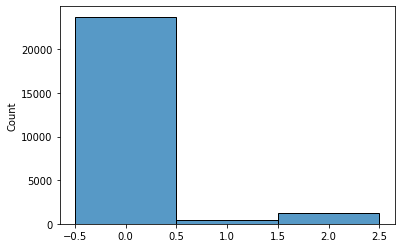

In [101]:
# Check the distribution of reactions
sns.histplot(y, discrete=True)

This is highly imbalanced, so we'll synthetically undersample the "no reaction" X data.

In [35]:
def downsample_zeros(X, y, rate=(1/6)):
    ''' Downsample class 0 with given rate '''
    X_keep = []
    y_keep = []
    for i in range(len(X)):
        if not (y[i] == 0 and random.random() > rate):
            X_keep.append(X[i])
            y_keep.append(y[i])
    return X_keep, np.array(y_keep)

In [102]:
X, y = downsample_zeros(X, y, rate=(1/8))

<AxesSubplot:ylabel='Count'>

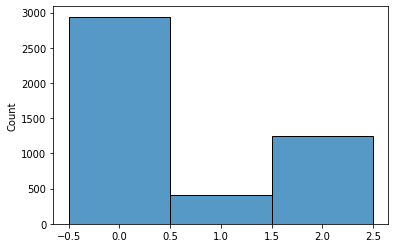

In [103]:
sns.histplot(y, discrete=True)

## Training and testing
First we define the Transformer model.

In [38]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [39]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [40]:
def defineTransformer(embed_dim=64, num_heads=2, ff_dim=32):
    ''' Define and return Transformer with given parameters '''
    inputs = layers.Input(shape=(MAXLEN,))
    embedding_layer = TokenAndPositionEmbedding(MAXLEN, VOCAB_SIZE, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(3, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [104]:
model = defineTransformer()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
token_and_position_embedding (None, 200, 64)           1292800   
_________________________________________________________________
transformer_block_3 (Transfo (None, 200, 64)           37664     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 64)                0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 20)                1300      
_________________________________________________________________
dropout_15 (Dropout)         (None, 20)                0   

### Data preparation

In [105]:
# Split data into train and testing data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [106]:
# Pad sequences to a constant length
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAXLEN)
X_val = keras.preprocessing.sequence.pad_sequences(X_val, maxlen=MAXLEN)

### Training and testing

In [107]:
N_EPOCHS = 5
# Weights for minority class enforcing
weights = {0: 1, 1: 1, 2: 1}

model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train, y_train, batch_size=5, epochs=N_EPOCHS, 
    validation_data=(X_val, y_val), 
    class_weight=weights,
    # Early stopping
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)]
)

Epoch 1/5
829/829 [==============================] - 37s 43ms/step - loss: 0.9032 - accuracy: 0.6268 - val_loss: 0.8514 - val_accuracy: 0.6312
Epoch 2/5
829/829 [==============================] - 38s 46ms/step - loss: 0.7717 - accuracy: 0.6547 - val_loss: 0.7299 - val_accuracy: 0.6790
Epoch 3/5
829/829 [==============================] - 40s 48ms/step - loss: 0.5330 - accuracy: 0.7790 - val_loss: 0.7849 - val_accuracy: 0.6356
Epoch 4/5
829/829 [==============================] - 40s 48ms/step - loss: 0.2672 - accuracy: 0.9043 - val_loss: 1.0289 - val_accuracy: 0.6399
Epoch 5/5
829/829 [==============================] - 39s 47ms/step - loss: 0.1451 - accuracy: 0.9527 - val_loss: 1.3452 - val_accuracy: 0.6746
Epoch 00005: early stopping


In [108]:
def plot_loss_history(history):
    ''' Plot training and validation loss over epochs '''
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0, len(loss_train))
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

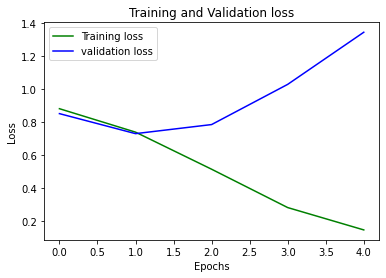

In [109]:
plot_loss_history(history)

In [110]:
# Make predictions
predictions = model.predict(X_val)
y_pred = np.argmax(predictions, axis=-1)

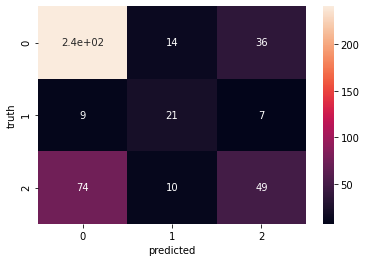

In [111]:
# Check confusion matrix
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True)
plt.xlabel("predicted")
plt.ylabel("truth")
plt.show()

### Qualitative test

In [122]:
toy_text = [
    "NNNNN", 
    "I'd like to tell you about a call I got once as a school receptionist.", 
    "The person said, is this the school?", 
    "I said, no, this is Patrick.", 
    "On a more serious note, we need to talk about some serious issues. Our future generations will thank us for finally coming around to this planet-threatening issue.",
    "Thank you."]

In [123]:
# Clean
toy_cleaned = clean_raw_text(toy_text)
toy_sentences = split_sentences(toy_cleaned)

In [124]:
# Create windows and pad
toy_X, _ = create_dataset(toy_sentences)
toy_X = keras.preprocessing.sequence.pad_sequences(toy_X, maxlen=maxlen)

In [125]:
# Make predictions
toy_pred = model.predict(toy_X)
toy_pred = np.argmax(toy_pred, axis=-1)

In [126]:
# Print reactions
for i, sent in enumerate([s for s in toy_sentences if s != NEXT]):
    print(sent)
    print(f">> REACTION: {reactions[toy_pred[i]]}")

I'd like to tell you about a call I got once as a school receptionist.
>> REACTION: 😐
The person said, is this the school?
>> REACTION: 😐
I said, no, this is Patrick.
>> REACTION: 😂
On a more serious note, we need to talk about some serious issues.
>> REACTION: 😐
Our future generations will thank us for finally coming around to this planet-threatening issue.
>> REACTION: 👏
Thank you.
>> REACTION: 👏


### Model persistence

In [ ]:
SAVE_INDEX = 1

In [ ]:
# Save model
model.save(f'transformer_{SAVE_INDEX}')

In [52]:
# Save encodings
with open(f'word_to_index_{SAVE_INDEX}.json', 'w') as f:
    json.dump(word_to_index, f)